#### Generative Adversarial Network in Keras

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [3]:
y_train.shape

(60000,)

In [4]:
n= len(X_train)
X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [5]:
X_train / 255., y_train / 255.

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0., ...,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0., ...,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0., ...,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0., ...,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.

#### Plot some digits

In [6]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

In [8]:
#Random data generator
def noise(bs): 
    return np.random.rand(bs,100)

In [10]:
#batch of real and generated data with appropriate lebels for discriminator
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X, [0]*sz + [1]*sz

In [11]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: 
        l.trainable = val

Train a few epochs, and return the losses for D and G. 
In each epoch we:

1. Train D on one batch from data_D()

2. Train G to create images that the discriminator predicts as real.

In [25]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(nb_epoch)):
        X,y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X,y))
        make_trainable(D, False)
        #D.compile(compile(Adam(1e-4), "binary_crossentropy"))
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
        #D.compile(compile(Adam(1e-4), "binary_crossentropy"))
    return dl,gl

#### We'll kee things simple and try plain ole' MLPs

In [20]:
MLP_G = Sequential([
    Dense(200, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(784, activation='sigmoid'),
])

In [21]:
MLP_D = Sequential([
    Dense(300, input_shape=(784,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
MLP_D.compile(Adam(1e-4), "binary_crossentropy")

In [23]:
MLP_m = Sequential([MLP_G,MLP_D])
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [26]:
dl,gl = train(MLP_D, MLP_G, MLP_m, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 1000/1000 [00:47<00:00, 22.24it/s]


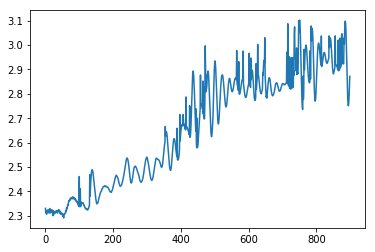

In [27]:
plt.plot(dl[100:])

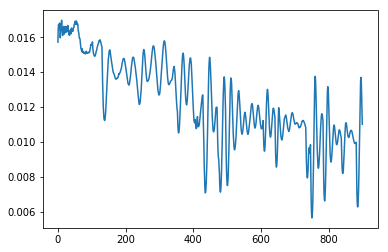

In [28]:
plt.plot(gl[100:])

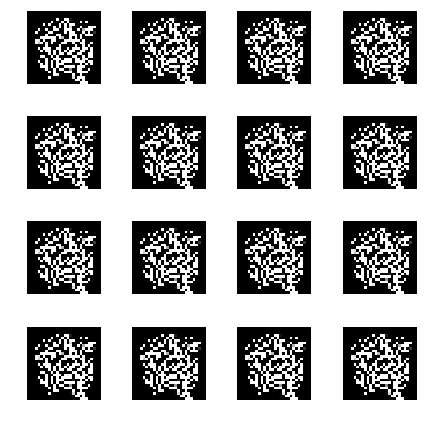

In [29]:
plot_gen(MLP_G)

In [30]:
#Use CNN instead of Vanilla MLP
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

In [36]:
CNN_G = Sequential([
    Dense(512*7*7, input_dim=100, activation=LeakyReLU()),
    BatchNormalization(),
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Convolution2D(64, 3, 3, border_mode='same', activation=LeakyReLU()),
    BatchNormalization(),
    UpSampling2D(),
    Convolution2D(32, 3, 3, border_mode='same', activation=LeakyReLU()),
    BatchNormalization(),
    Convolution2D(1, 1, 1, border_mode='same', activation='sigmoid')
])

/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))
/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation=<keras.lay...)`
  
/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation=<keras.lay...)`
  if __name__ == '__main__':
/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="s

In [40]:
CNN_D = Sequential([
    Conv2D(256, (5, 5), subsample=(2,2), border_mode='same', 
                  input_shape=(28, 28, 1), activation=LeakyReLU()),
    Conv2D(512, (5, 5), subsample=(2,2), border_mode='same', activation=LeakyReLU()),
    Flatten(),
    Dense(256, activation=LeakyReLU()),
    Dense(1, activation = 'sigmoid')
])

/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (5, 5), padding="same", input_shape=(28, 28, 1..., strides=(2, 2), activation=<keras.lay...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))
/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 5), padding="same", strides=(2, 2), activation=<keras.lay...)`
  after removing the cwd from sys.path.


In [43]:
CNN_D.compile(Adam(1e-3), "binary_crossentropy")

In [44]:
sz = n//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, epochs=1, verbose=2)

Epoch 1/1
 - 23s - loss: 3.4745


In [45]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [46]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

In [47]:
dl,gl = train(CNN_D, CNN_G, CNN_m, 2500)

  0%|          | 0/2500 [00:00<?, ?it/s]/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 2500/2500 [46:31:09<00:00, 12.74s/it]      


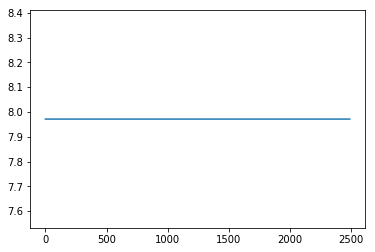

In [51]:
plt.plot(dl[10:])

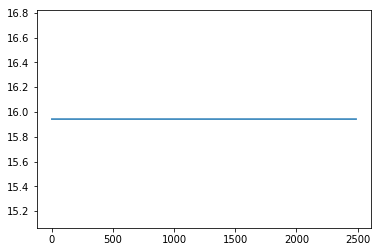

In [52]:
plt.plot(gl[10:])

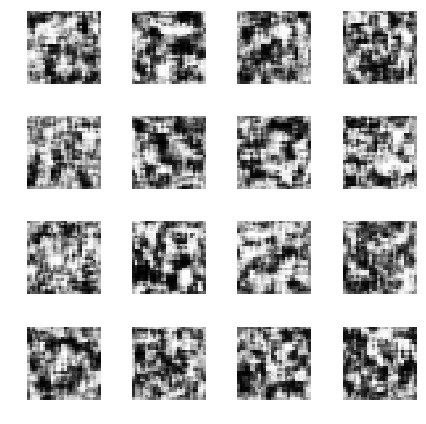

In [53]:
plot_gen(CNN_G)